# Sommelier inteligente

## Visão geral e objetivos

A objetivo da aplicação é gerar um modelo e aplicação em aprendizado de máquina denominada Sommelier Inteligente que automaticamente reconheça um determinado tipo de vinho considerando os conjunto de dados no repositório: https://archive.ics.uci.edu/ml/datasets/wine

# Passo 1. Setup do projeto

In [62]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn 
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

print('Matplot version : {}'.format(matplotlib.__version__))
print('Numpy version : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

WINE_ROOT = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/'
WINE_URL  = WINE_ROOT + 'wine.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'wine.csv'
WINE_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', '', 'model')
DEPLOY_FILE = 'finalized_model.sav'
#DEPLOY_FILE = datetime.now().strftime("%Y%m%d_%H%M%S") + '_finalized_model.sav'


Matplot version : 3.3.2
Numpy version : 1.19.2
Pandas version : 1.1.3
Sklearn version : 0.23.2


#  Passo 2. Recuperação dos dados

In [63]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

In [64]:
download_data(WINE_URL, DATA_PATH, DATA_FILE)

In [65]:

def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['name', 'alcohol', 'malic_acid', 
                                                        'ash', 'alcalinity_of_ash', 
                                                        'magnesium', 'total_phenols',
                                                        'flavanoids', 'nonflavanoid_phenols',
                                                        'proanthocyanins', 'color_intensity',
                                                        'hue', 'OD280/OD315_of_diluted_wines',
                                                        'proline'])

In [66]:
wine_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3. Análise Exploratória de Dados

In [67]:
wine_data.head()

name  alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  \
0     1    14.23        1.71  2.43               15.6        127   
1     1    13.20        1.78  2.14               11.2        100   
2     1    13.16        2.36  2.67               18.6        101   
3     1    14.37        1.95  2.50               16.8        113   
4     1    13.24        2.59  2.87               21.0        118   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   color_intensity   hue  OD280/OD315_of_diluted_wines  proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05                          3.40     1050  
2             5.68  1.03                          3.17     1185  
3             7.80  0.86                          3.45     1480  
4             4.32  1.04                          2.93      735

In [68]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  OD280/OD315_of_diluted_wines  178 non-null    float64
 13  proli

In [69]:
wine_data.describe()

name     alcohol  malic_acid         ash  alcalinity_of_ash  \
count  178.000000  178.000000  178.000000  178.000000         178.000000   
mean     1.938202   13.000618    2.336348    2.366517          19.494944   
std      0.775035    0.811827    1.117146    0.274344           3.339564   
min      1.000000   11.030000    0.740000    1.360000          10.600000   
25%      1.000000   12.362500    1.602500    2.210000          17.200000   
50%      2.000000   13.050000    1.865000    2.360000          19.500000   
75%      3.000000   13.677500    3.082500    2.557500          21.500000   
max      3.000000   14.830000    5.800000    3.230000          30.000000   

        magnesium  total_phenols  flavanoids  nonflavanoid_phenols  \
count  178.000000     178.000000  178.000000            178.000000   
mean    99.741573       2.295112    2.029270              0.361854   
std     14.282484       0.625851    0.998859              0.124453   
min     70.000000       0.980000    0.340000              0.130000   
25%     88.000000       1.742500    1.205000              0.270000   
50%     98.000000       2.355000    2.135000              0.340000   
75%    107.000000       2.800000    2.875000              0.437500   
max    162.000000       3.880000    5.080000              0.660000   

       proanthocyanins  color_intensity         hue  \
count       178.000000       178.000000  178.000000   
mean          1.590899         5.058090    0.957449   
std           0.572359         2.318286    0.228572   
min           0.410000         1.280000    0.480000   
25%           1.250000         3.220000    0.782500   
50%           1.555000         4.690000    0.965000   
75%           1.950000         6.200000    1.120000   
max           3.580000        13.000000    1.710000   

       OD280/OD315_of_diluted_wines      proline  
count                    178.000000   178.000000  
mean                       2.611685   746.893258  
std                        0.709990   314.907474  
min                        1.270000   278.000000  
25%                        1.937500   500.500000  
50%                        2.780000   673.500000  
75%                        3.170000   985.000000  
max                        4.000000  1680.000000

# Correlação e distribuição

In [70]:
X = wine_data[['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols',
'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
'hue', 'OD280/OD315_of_diluted_wines', 'proline']]

y = wine_data['name']

<AxesSubplot:xlabel='name', ylabel='color_intensity'>

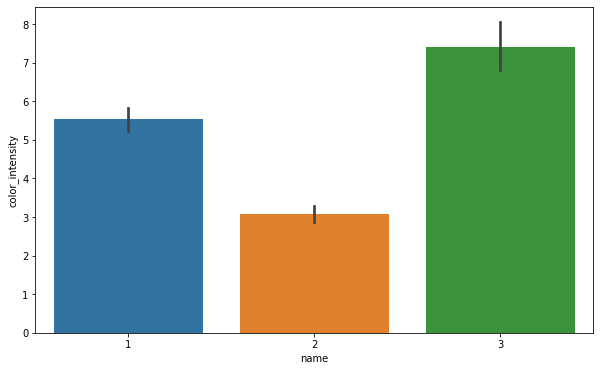

In [72]:
#Intensidade da cor é bem distinta entre as Classes 
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'name', y = 'color_intensity', data = wine_data)

<AxesSubplot:xlabel='name', ylabel='alcohol'>

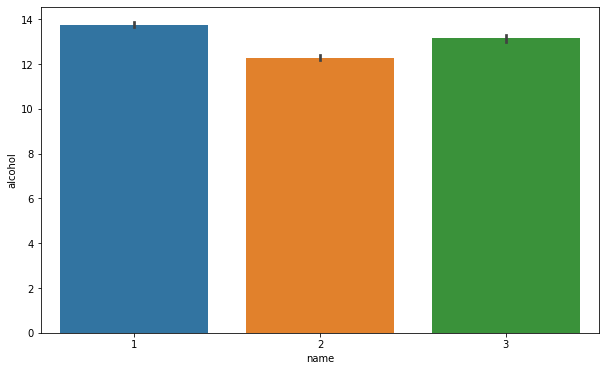

In [76]:
#Concentraçao alcoolica não é um grande diferencial entre as classes.
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'name', y = 'alcohol', data = wine_data)

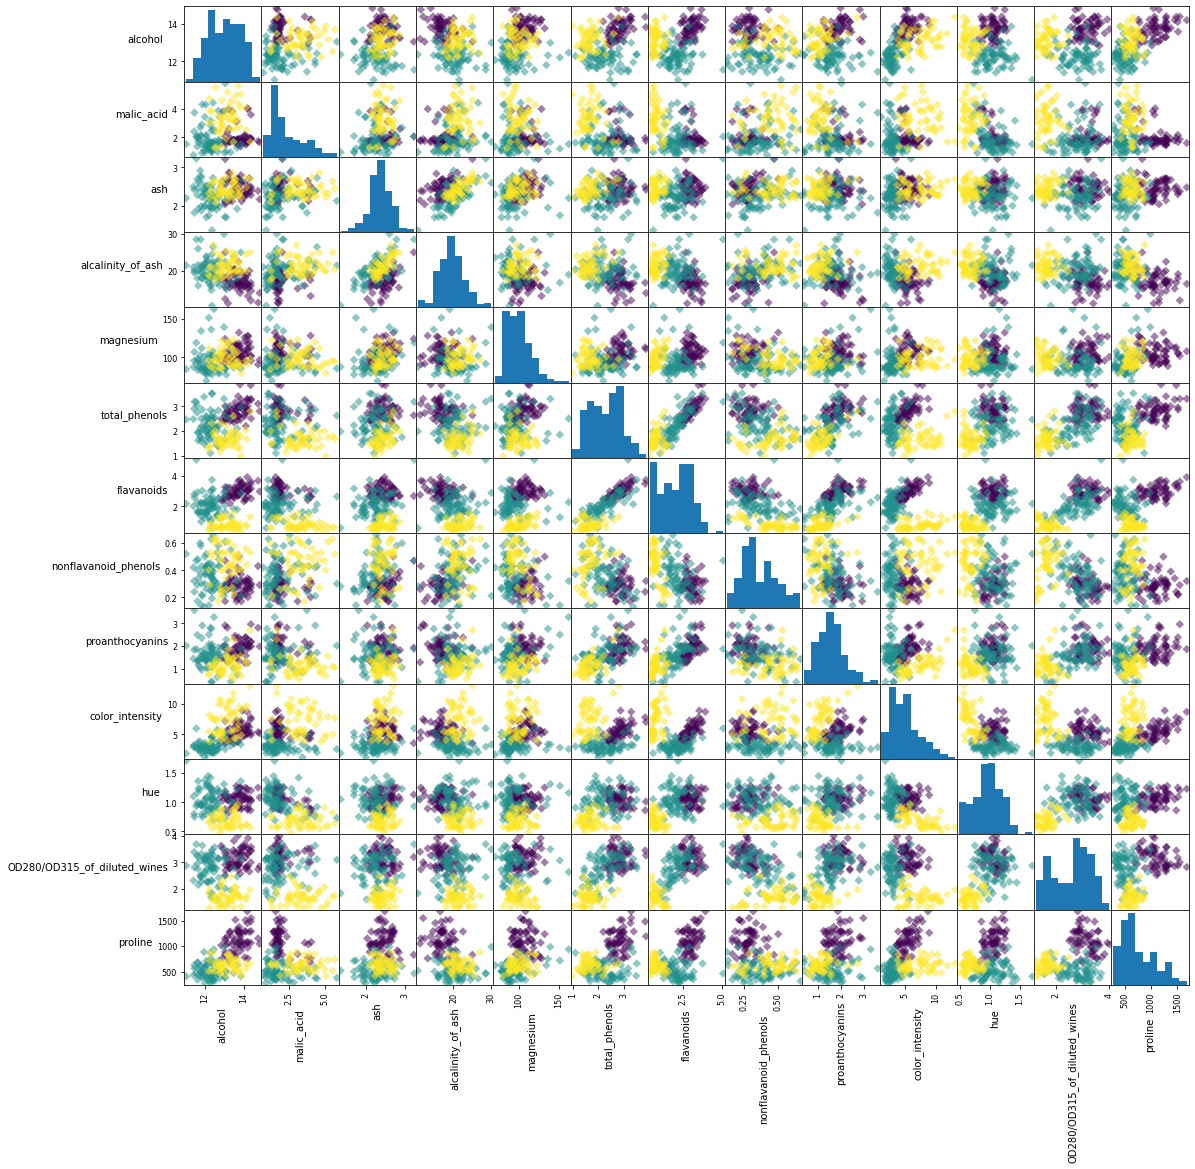

In [75]:
cores = y.astype('category').cat.codes
_ = pd.plotting.scatter_matrix(X, c=cores, figsize=[18, 18], marker='D')

for ax in _.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

# Passo 4: Treinamento do Modelo

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)

In [78]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy  = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i]  = knn.score(X_test, y_test)

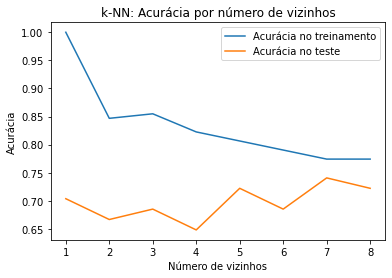

In [79]:
plt.title('k-NN: Acurácia por número de vizinhos')
plt.plot(neighbors, train_accuracy, label='Acurácia no treinamento')
plt.plot(neighbors, test_accuracy, label='Acurácia no teste')
plt.legend()
plt.xlabel('Número de vizinhos')
plt.ylabel('Acurácia')
plt.show()

In [80]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

# Passo 5: Testar o modelo

In [81]:
predicoes = model.predict(X_test)
print('Predições: {}'.format(predicoes))
[['1']][0]

Predições: [1 2 1 1 1 1 2 3 2 3 2 3 3 2 1 3 2 1 1 3 2 1 3 3 3 3 1 3 1 3 3 2 3 2 3 3 3
 3 3 1 3 1 1 1 1 2 2 1 3 3 2 2 3 1]


['1']

In [82]:
acuracia = model.score(X_test, y_test)
print("Acurácia do model: {}".format(acuracia))

Acurácia do model: 0.7407407407407407


# Passo 6. Deploy do modelo

In [83]:
local_path = os.path.join(DEPLOY_PATH, DEPLOY_FILE)
joblib.dump(model, local_path)

['..\\model\\finalized_model.sav']